In [131]:
import numpy as np
from numpy.polynomial.chebyshev import Chebyshev, chebpts2, chebpts1
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt

Let $X$ be a continuous random variable with support $(-\infty, \infty)$.
Then, define the random variable $Y$ by $Y = \tanh(X)$.
Note that the support of $Y$ is $(-1, 1)$.
Also, because $\tanh$ is a monotone increasing function, we can easily calculate the PDF of $Y$.
It is given by $f_Y(y) = f_X(\tanh^{-1}(y)) \frac{1}{1-y^2}$, where $f_X$ is the PDF of $X$.
We can then approximate $f_Y$ by a polynomial $g_{Y,n}$ of degree $n$ by evaluating $f_Y$ at the $n$-th degree Chebyshev extremizers.
An example of this for $X \sim \mathcal{N}(0, 1)$ and $n = 50$ is shown below.
As a quick sanity check, we also plot a histogram for $Y$ by actually sampling from $Y$ by sampling from $X$ and then applying $\tanh$.

/var/folders/58/lhtws_7x3zs3hk8mh5kznkf00000gn/T/ipykernel_99115/3517916098.py:1: RuntimeWarning: divide by zero encountered in arctanh
  f_Y = lambda y: np.where(np.isin(y, [-1,1]), 0, stats.norm.pdf(np.arctanh(y)) / (1 - y**2))
/var/folders/58/lhtws_7x3zs3hk8mh5kznkf00000gn/T/ipykernel_99115/3517916098.py:1: RuntimeWarning: invalid value encountered in divide
  f_Y = lambda y: np.where(np.isin(y, [-1,1]), 0, stats.norm.pdf(np.arctanh(y)) / (1 - y**2))


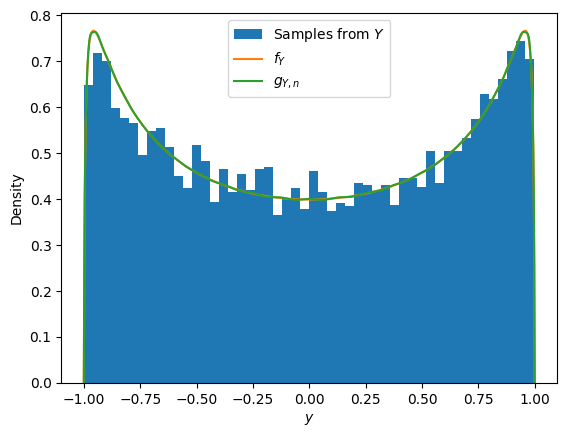

In [127]:
f_Y = lambda y: np.where(np.isin(y, [-1,1]), 0, stats.norm.pdf(np.arctanh(y)) / (1 - y**2))
n = 50
g_Yn = Chebyshev.fit(chebpts2(n), f_Y(chebpts2(n)), n, domain=[-1, 1])

x = stats.norm.rvs(size=10000)
y = np.tanh(x)
plt.hist(y, density=True, bins=50, label='Samples from $Y$')

dom = np.linspace(-1, 1, 1000)
plt.plot(dom, f_Y(dom), label='$f_Y$')
plt.plot(dom, g_Yn(dom), label='$g_{Y,n}$')
plt.xlabel('$y$')
plt.ylabel('Density')
plt.legend()
plt.show()

As you can see, $g_{Y,50}$ is a pretty good approximation to $f_Y$.

Using this, we can find an approximation for the CDF of $Y$, call it $G_{Y,n}$ by integrating $g_{Y,n}$.
We did not constrain $g_{Y,n}$ to be a probability density function, so when finding $G_{Y,n}$, we need to divide by the total area under $g_{Y,n}$.
Therefore, define $G_{Y,n}$ by
$$
G_{Y,n}(y) = \frac{\int_{-1}^y g_{Y,n}(z) dz}{Z}
$$
where $Z_{Y,n} = \int_{-1}^1 g_{Y,n}(z) dz$ is the (approximate) normalization constant.
Once we have $G_{Y,n}$, we can find the inverse of $G_{Y,n}$, call it $Q_{Y,n}$, by solving $G_{Y,n}^{-1}(x) = y$ for $y$.
This is an approximation for the quantile function of $Y$.
This can be done by using Newton's method on the equation $G_{Y,n}(y) - x = 0$.

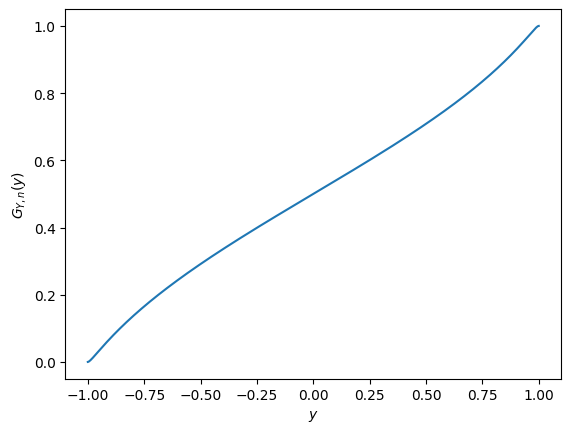

In [130]:
g_Yn_int = g_Yn.integ(lbnd=-1)
Z_Yn = g_Yn_int(1)
G_Yn = lambda y: g_Yn_int(y)/Z_Yn

plt.plot(dom, G_Yn(dom))
plt.xlabel('$y$')
plt.ylabel('$G_{Y,n}(y)$')
plt.show()

One thing to point out is that $G_{Y,n}$ has undefined, and probably erratic behavior when $y$ is outside of the support of $Y$.
This can cause Newton's method to converge to something outside of the support of $Y$.
Therefore, we will modify the Newton objective so that it is a truly monotone increasing function.
To do this, we will use the fact that $G_{Y,n}$ is a strictly increasing function on $(-1, 1)$.
Outside of this range, we will have a "half"-parabola whose coefficients are chosen to match the derivative of $G_{Y,n}$ at the endpoints of the range.
For the left endpoint the parabola that matches the derivative is
$$
p(y) = -y^2 + (g_{Y,n}(-1) - 2) y + g_{Y,n}(-1) - 1
$$
with derivative
$$
p'(y) = -2y + g_{Y,n}(-1) - 2
$$
For the right endpoint, the parabola that matches the derivative is
$$
p(y) = y^2 + (g_{Y,n}(1) - 2) y - g_{Y,n}(1) + 2
$$
with derivative
$$
p'(y) = 2y + g_{Y,n}(1) - 2
$$

In [139]:
def Q_Yn(x):
    # Define the objective function and its derivative
    def newt_obj(y): return np.where(y < -1,
                                     -y**2 + (g_Yn(-1)/Z_Yn - 2) *
                                     y + g_Yn(-1)/Z_Yn - 1 - x,
                                     np.where(y > 1,
                                              y**2 + (g_Yn(1)/Z_Yn - 2) *
                                              y + g_Yn(1)/Z_Yn + 2 - x,
                                              G_Yn(y) - x
                                              )
                                     )

    def newt_obj_prime(y): return np.where(y < -1,
                                           -2 * y + g_Yn(-1)/Z_Yn - 2,
                                           np.where(y > 1,
                                                    2 * y + g_Yn(1)/Z_Yn - 2,
                                                    g_Yn(y)/Z_Yn
                                                    )
                                           )

    # A good initial guess is x
    y = optimize.newton(newt_obj, np.full_like(
        x, .5), fprime=newt_obj_prime, tol=1e-10, maxiter=1000)

    return y


Now that we have $Q_{Y,n}$, we can use it to sample from $Y$ using inversion sampling.

/var/folders/58/lhtws_7x3zs3hk8mh5kznkf00000gn/T/ipykernel_99115/3517916098.py:1: RuntimeWarning: divide by zero encountered in arctanh
  f_Y = lambda y: np.where(np.isin(y, [-1,1]), 0, stats.norm.pdf(np.arctanh(y)) / (1 - y**2))
/var/folders/58/lhtws_7x3zs3hk8mh5kznkf00000gn/T/ipykernel_99115/3517916098.py:1: RuntimeWarning: invalid value encountered in divide
  f_Y = lambda y: np.where(np.isin(y, [-1,1]), 0, stats.norm.pdf(np.arctanh(y)) / (1 - y**2))


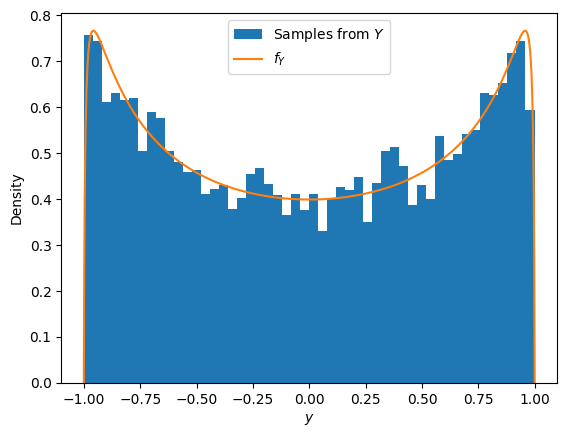

In [141]:
u = stats.uniform.rvs(size=10000)
y = Q_Yn(u)

plt.hist(y, density=True, bins=50, label='Samples from $Y$')
plt.plot(dom, f_Y(dom), label='$f_Y$')
plt.xlabel('$y$')
plt.ylabel('Density')
plt.legend()
plt.show()

Finally, we can use the samples from $Y = \tanh(X)$ to sample from $X = \tanh^{-1}(Y)$.

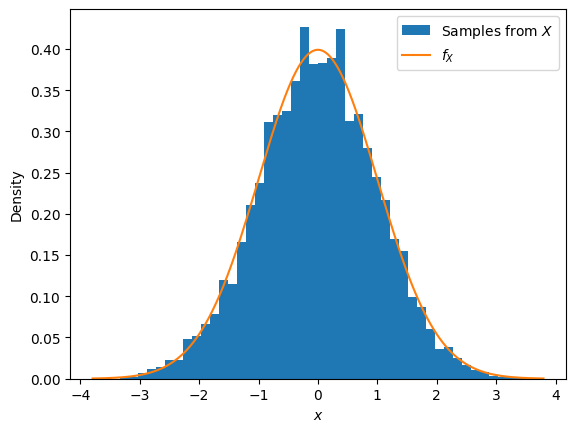

In [143]:
x = np.arctanh(y)

dom = np.linspace(np.min(x), np.max(x), 1000)
plt.hist(x, density=True, bins=50, label='Samples from $X$')
plt.plot(dom, stats.norm.pdf(dom), label='$f_X$')
plt.xlabel('$x$')
plt.ylabel('Density')
plt.legend()
plt.show()